<h1 style="float:center;" align="center">Computer Assignment 5 Phase 2</h1>
<h3 style="float:center;" align="center"><b> Ali Javdian ( 810896047 ) </b></h3>

In [5]:
from tensorflow.keras import *
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import tensorboard

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp "/content/drive/MyDrive/xray.zip" .

In [8]:
!unzip xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/train/COVID19/COVID19(228).jpg  
  inflating: Data/train/COVID19/COVID19(229).jpg  
  inflating: Data/train/COVID19/COVID19(23).jpg  
  inflating: Data/train/COVID19/COVID19(230).jpg  
  inflating: Data/train/COVID19/COVID19(231).jpg  
  inflating: Data/train/COVID19/COVID19(232).jpg  
  inflating: Data/train/COVID19/COVID19(233).jpg  
  inflating: Data/train/COVID19/COVID19(234).jpg  
  inflating: Data/train/COVID19/COVID19(235).jpg  
  inflating: Data/train/COVID19/COVID19(236).jpg  
  inflating: Data/train/COVID19/COVID19(237).jpg  
  inflating: Data/train/COVID19/COVID19(238).jpg  
  inflating: Data/train/COVID19/COVID19(239).jpg  
  inflating: Data/train/COVID19/COVID19(24).jpg  
  inflating: Data/train/COVID19/COVID19(240).jpg  
  inflating: Data/train/COVID19/COVID19(241).jpg  
  inflating: Data/train/COVID19/COVID19(242).jpg  
  inflating: Data/train/COVID19/COVID19(243).jpg  
  inflating: Data/train/COVID19/C

# Q1: Loading Dataset

In [9]:
def resetDataset(batch_size=32, scale=None):
  imgDataLoader = preprocessing.image.ImageDataGenerator(
      rescale=scale,
  )
  trainLoader = imgDataLoader.flow_from_directory(
    "/content/Data/train",
    target_size=(80, 80),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
  ) 
  
  testLoader = imgDataLoader.flow_from_directory(
    "/content/Data/test",
    target_size=(80, 80),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
  )
  
  return trainLoader, testLoader

In [10]:
trainLoader, testLoader = resetDataset()

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# Q2: Analyse Dataset

In [11]:
batch_img, batch_label = trainLoader.next()

# Plot image of each class

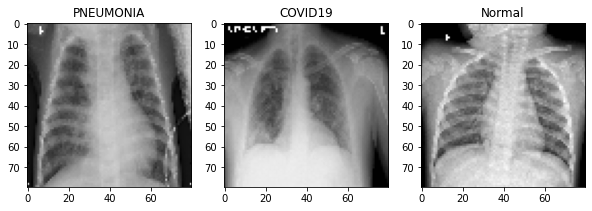

In [12]:
seen_labels = set()
fig, ax = plot_container = plt.subplots(1, 3)
fig.set_size_inches(10, 4)
ax_index = 0
classes_lables = {0: "COVID19", 1: "Normal", 2: "PNEUMONIA"}
for img, label in zip(batch_img, batch_label):
  class_label = backend.argmax(label).numpy()
  if class_label not in seen_labels:
    ax[ax_index].imshow(img.reshape(80, 80), cmap='gray') 
    ax[ax_index].set_title(classes_lables[class_label])
    ax_index+=1
    seen_labels.add(class_label)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


<BarContainer object of 3 artists>

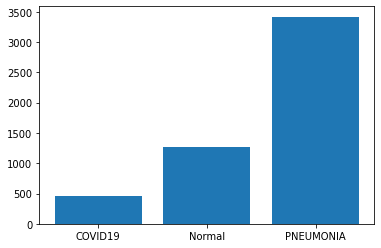

In [13]:
trainLoader, testLoader = resetDataset()
num_classes = trainLoader.num_classes
classes_lables_count = {i:0 for i in range(num_classes)}
for label in trainLoader.classes:
  classes_lables_count[label] += 1
x_labels = [classes_lables[i] for i in range(num_classes)]
y_labels = [classes_lables_count[i] for i in range(num_classes)]
plt.bar(x_labels, y_labels)

# Q3: Define Neural Network structure

Here we define our first model. In this model, our database isn't normalized so we don't expect to get good results out of this model. Because we have a high variance here and our data input is big, between 0 to 255, and hence we should get high loss in our model.

After fitting the dataset to the model, we see that our loss is nan. The reason for this problem is Normalization. We don't normalize the dataset we got so the data input is between 0 to 255 and these values are very big and cause the gradient in each step to become bigger and bigger, and after a few steps it becomes very big and so it overflows and python shows it as nan. For solving this problem, we should normalize our dataset, which we will do in next part. It's worth mentioning that this nan values could be solved by reducing the learning rate or increasing in the numbers of layers.

In [14]:
def getTrueLabels(loader):
  labels = []
  total_batchs = int(np.ceil(len(loader.classes)/loader.batch_size))
  for i in range(total_batchs):
    x, y = loader.next()
    for label in y:
      labels.append(backend.argmax(label))
  return np.array(labels)

In [15]:
def createModel(input_shape, output_class_count, activation='relu', optimizer=optimizers.SGD(learning_rate=0.01), initializer=None, kernel_regularizer=None, loss='categorical_crossentropy'):
  input_layer = layers.Input(shape=input_shape)
  input_flatten = layers.Flatten()(input_layer)
  output = layers.Dense(2048, activation=activation, kernel_initializer=initializer, bias_initializer=initializer, kernel_regularizer=kernel_regularizer)(input_flatten)
  output = layers.Dense(4096, activation=activation, kernel_initializer=initializer, bias_initializer=initializer, kernel_regularizer=kernel_regularizer)(output)
  output = layers.Dense(4096, activation=activation, kernel_initializer=initializer, bias_initializer=initializer, kernel_regularizer=kernel_regularizer)(output)
  output = layers.Dense(1024, activation=activation, kernel_initializer=initializer, bias_initializer=initializer, kernel_regularizer=kernel_regularizer)(output)
  output = layers.Dense(4096, activation=activation, kernel_initializer=initializer, bias_initializer=initializer)(output)
  output = layers.Dense(output_class_count, activation="softmax", kernel_initializer=initializer, bias_initializer=initializer)(output)
  model = models.Model(
      inputs=input_layer,
      outputs=output
  )
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [16]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              13109248  
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              419840

In [18]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 173s 1s/step - loss: nan - accuracy: 0.1144 - val_loss: nan - val_accuracy: 0.0901
Epoch 2/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0862 - val_loss: nan - val_accuracy: 0.0901
Epoch 3/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0960 - val_loss: nan - val_accuracy: 0.0901
Epoch 4/10
161/161 [==============================] - 169s 1s/step - loss: nan - accuracy: 0.0874 - val_loss: nan - val_accuracy: 0.0901
Epoch 5/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.0901
Epoch 6/10
161/161 [==============================] - 169s 1s/step - loss: nan - accuracy: 0.0959 - val_loss: nan - val_accuracy: 0.0901
Epoch 7/10
161/161 [==============================] - 169s 1s/step - loss: nan - accuracy: 0.0864 - val_loss: nan - val_accuracy: 0.0901
Epoch 8/10
161/161 [=====================

In [19]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.09      1.00      0.17       116
           1       0.00      0.00      0.00       317
           2       0.00      0.00      0.00       855

    accuracy                           0.09      1288
   macro avg       0.03      0.33      0.06      1288
weighted avg       0.01      0.09      0.01      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.09      1.00      0.16       460
           1       0.00      0.00      0.00      1266
           2       0.00      0.00      0.00      3418

    accuracy                           0.09      5144
   macro avg       0.03      0.33      0.05      5144
weighted avg       0.01      0.09      0.01      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Q4: comparison of Relu and Tanh on non-normalized data

In [21]:
def plotTraining(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.show()

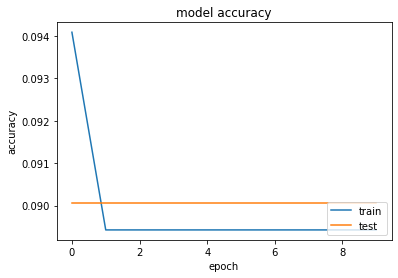

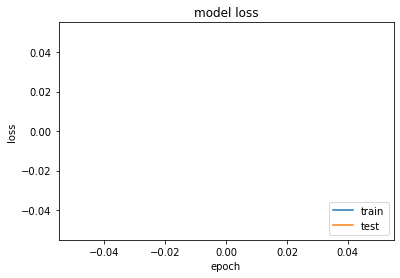

In [22]:
plotTraining(history)

In [23]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, activation='tanh')

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              13109248  
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_10 (Dense)             (None, 4096)              4198

In [26]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 170s 1s/step - loss: 0.9348 - accuracy: 0.6392 - val_loss: 0.8376 - val_accuracy: 0.6638
Epoch 2/10
161/161 [==============================] - 167s 1s/step - loss: 0.8358 - accuracy: 0.6645 - val_loss: 0.8750 - val_accuracy: 0.6638
Epoch 3/10
161/161 [==============================] - 164s 1s/step - loss: 0.8393 - accuracy: 0.6645 - val_loss: 0.8341 - val_accuracy: 0.6638
Epoch 4/10
161/161 [==============================] - 163s 1s/step - loss: 0.8359 - accuracy: 0.6645 - val_loss: 0.8334 - val_accuracy: 0.6638
Epoch 5/10
161/161 [==============================] - 161s 1s/step - loss: 0.8331 - accuracy: 0.6645 - val_loss: 0.8346 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 159s 989ms/step - loss: 0.8336 - accuracy: 0.6645 - val_loss: 0.8299 - val_accuracy: 0.6638
Epoch 7/10
161/161 [==============================] - 159s 987ms/step - loss: 0.8325 - accuracy: 0.6645 - val_loss: 0.8363 - val_accuracy: 

In [27]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


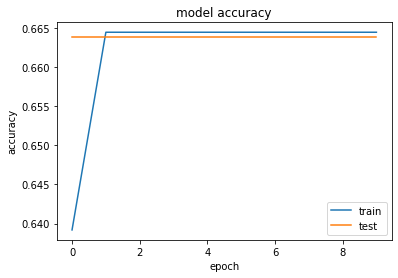

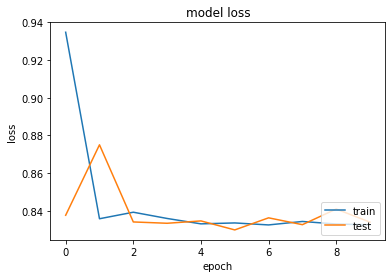

In [29]:
plotTraining(history)

Solution to due problem is to normalize dataset.

# Q5

In this section, we will normalize our dataset to get rid of nan values in the previous section.



Here we can see that our model works logically, and the training loss becomes smaller in each epoch. This means that our model is working correctly and we have a good model here that fit to the dataset well.

The difference between this section and the previous one is just the normalization of the dataset. Normalizing means that we scale the data, which is between 0 to 255, to the range of 0 to 1. This helps the loss calculation because the values become smaller, and the gradients' values in each step didn't become very large and update normally and sufficiently updated the weights, and thus the model works well.

In [30]:
trainLoader, testLoader = resetDataset(scale=1.0/255.0)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [31]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes)

In [32]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              4198

In [34]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 164s 1s/step - loss: 0.6108 - accuracy: 0.7321 - val_loss: 0.3731 - val_accuracy: 0.8789
Epoch 2/10
161/161 [==============================] - 161s 1s/step - loss: 0.4276 - accuracy: 0.8301 - val_loss: 0.2602 - val_accuracy: 0.9177
Epoch 3/10
161/161 [==============================] - 167s 1s/step - loss: 0.3515 - accuracy: 0.8602 - val_loss: 0.6554 - val_accuracy: 0.6630
Epoch 4/10
161/161 [==============================] - 169s 1s/step - loss: 0.3055 - accuracy: 0.8804 - val_loss: 0.2058 - val_accuracy: 0.9247
Epoch 5/10
161/161 [==============================] - 170s 1s/step - loss: 0.2851 - accuracy: 0.8921 - val_loss: 0.2739 - val_accuracy: 0.8913
Epoch 6/10
161/161 [==============================] - 170s 1s/step - loss: 0.2820 - accuracy: 0.8956 - val_loss: 0.1808 - val_accuracy: 0.9356
Epoch 7/10
161/161 [==============================] - 170s 1s/step - loss: 0.2531 - accuracy: 0.9028 - val_loss: 0.3237 - val_accuracy: 0.8750

In [40]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

ValueError: ignored

In [39]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       460
           1       0.24      0.21      0.22      1266
           2       0.66      0.70      0.68      3418

    accuracy                           0.52      5144
   macro avg       0.33      0.33      0.33      5144
weighted avg       0.51      0.52      0.51      5144



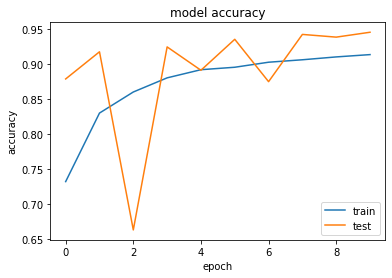

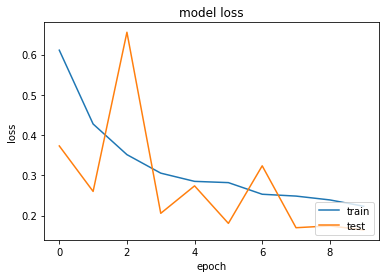

In [38]:
plotTraining(history)

The learning rate controls how quickly the model is adapted to the problem. 
* **Very Big Learning Rate**: 
    1. Generally, a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. 
    2. A learning rate that is too large will result in weight updates that will be too large and the performance of the model (such as its loss on the training dataset) will oscillate over training epochs. Oscillating performance is said to be caused by weights that diverge (are divergent). 
    3. When using high learning rates, it is possible to encounter a positive feedback loop in which large weights induce large gradients which then induce a large update to the weights. If these updates consistently increase the size of the weights, then the weight rapidly moves away from the origin until numerical overflow occurs.

* **Very Small Learning Rate**: 
    1. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train.  
    2. A learning rate that is too small may never converge or may get stuck on a suboptimal solution.

# Q6

In this section we check out effect of the momentum hyperparameter in optimizer. SGD with momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging. What we get with this is an exponentially weighted moving average of the gradient, implying the progress is faster when we move in the right direction and the possible oscillation when we rebound in the loss function. Both features make convergence happen.

**Pros**: With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are noisy. So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations. This is one reason why momentum might work better than classic SGD.

The other reason lies in ravines. Ravine is an area, where the surface curves much more steeply in one dimension than in another. Ravines are common near local minimas in deep learning and SGD has troubles navigating them. SGD will tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum. Momentum helps accelerate gradients in the right direction.

**Cons**: If the momentum is too much, we will most likely miss the local minima, rolling past it, but then rolling backwards, missing it again. If the momentum is too much, we could just swing back and forward between the local minima.

In this section, we will try different momentum for finding the best one for our model. As you can see, we try 0.5, 0.9 and 0.99 for the momentum parameter. But as much as I increase the momentum parameter, the accuracy of my model decreases and in the last try with 0.99 my model didn't even fit dataset and the train_loss becomes nan. The reason for this happens is that when we increase the momentum, the gradients become bigger and bigger and after some step the gradient becomes Inf and leads to the nan in the loss.

As we state in the cons of the momentum, large momentum can lead to missing local optimum and hence is not good.

# momentum=0.5

In [41]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5))

In [42]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_19 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_20 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_22 (Dense)             (None, 4096)              4198

In [43]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 163s 1s/step - loss: 0.6435 - accuracy: 0.7180 - val_loss: 0.3096 - val_accuracy: 0.9107
Epoch 2/10
161/161 [==============================] - 160s 996ms/step - loss: 0.3452 - accuracy: 0.8745 - val_loss: 0.4455 - val_accuracy: 0.8292
Epoch 3/10
161/161 [==============================] - 159s 988ms/step - loss: 0.2979 - accuracy: 0.8806 - val_loss: 0.2212 - val_accuracy: 0.9169
Epoch 4/10
161/161 [==============================] - 158s 976ms/step - loss: 0.2660 - accuracy: 0.8931 - val_loss: 0.1915 - val_accuracy: 0.9262
Epoch 5/10
161/161 [==============================] - 158s 983ms/step - loss: 0.2261 - accuracy: 0.9081 - val_loss: 0.1827 - val_accuracy: 0.9309
Epoch 6/10
161/161 [==============================] - 158s 978ms/step - loss: 0.2298 - accuracy: 0.9164 - val_loss: 0.1729 - val_accuracy: 0.9441
Epoch 7/10
161/161 [==============================] - 157s 980ms/step - loss: 0.2133 - accuracy: 0.9193 - val_loss: 0.1623 - va

In [45]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.13      0.09      0.11       116
           1       0.26      0.36      0.30       317
           2       0.67      0.60      0.64       855

    accuracy                           0.50      1288
   macro avg       0.35      0.35      0.35      1288
weighted avg       0.52      0.50      0.51      1288



In [46]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.07      0.05      0.06       460
           1       0.26      0.37      0.30      1266
           2       0.67      0.58      0.62      3418

    accuracy                           0.48      5144
   macro avg       0.33      0.34      0.33      5144
weighted avg       0.52      0.48      0.49      5144



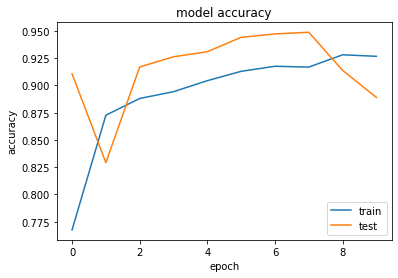

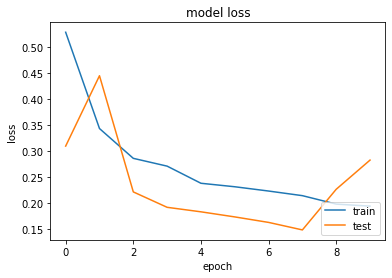

In [47]:
plotTraining(history)

# momentum=0.9

In [48]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9))

In [49]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_26 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_28 (Dense)             (None, 4096)              4198

In [50]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 162s 1s/step - loss: 0.6793 - accuracy: 0.6962 - val_loss: 0.3301 - val_accuracy: 0.8626
Epoch 2/10
161/161 [==============================] - 158s 984ms/step - loss: 0.3520 - accuracy: 0.8743 - val_loss: 0.1955 - val_accuracy: 0.9224
Epoch 3/10
161/161 [==============================] - 158s 980ms/step - loss: 0.2937 - accuracy: 0.8878 - val_loss: 0.2043 - val_accuracy: 0.9270
Epoch 4/10
161/161 [==============================] - 156s 972ms/step - loss: 0.2849 - accuracy: 0.8956 - val_loss: 0.2485 - val_accuracy: 0.9014
Epoch 5/10
161/161 [==============================] - 157s 975ms/step - loss: 0.2588 - accuracy: 0.9033 - val_loss: 0.1788 - val_accuracy: 0.9387
Epoch 6/10
161/161 [==============================] - 155s 966ms/step - loss: 0.2553 - accuracy: 0.9069 - val_loss: 0.1773 - val_accuracy: 0.9363
Epoch 7/10
161/161 [==============================] - 154s 957ms/step - loss: 0.2275 - accuracy: 0.9139 - val_loss: 0.1721 - va

In [52]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.07      0.05      0.06       116
           1       0.26      0.21      0.24       317
           2       0.66      0.73      0.70       855

    accuracy                           0.54      1288
   macro avg       0.33      0.33      0.33      1288
weighted avg       0.51      0.54      0.52      1288



In [53]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.08      0.06      0.07       460
           1       0.27      0.21      0.24      1266
           2       0.68      0.75      0.71      3418

    accuracy                           0.55      5144
   macro avg       0.34      0.34      0.34      5144
weighted avg       0.52      0.55      0.54      5144



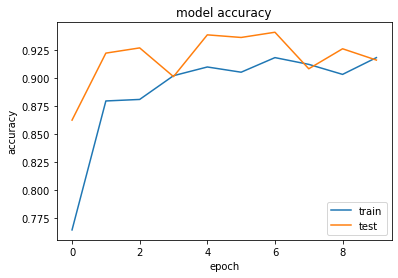

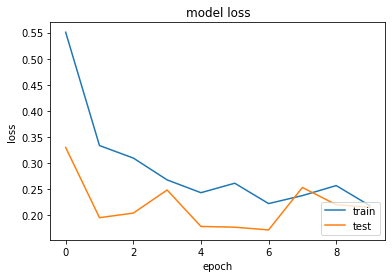

In [54]:
plotTraining(history)

# momentum=0.99

In [55]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.99))

In [56]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_31 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_32 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_34 (Dense)             (None, 4096)              4198

In [57]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 159s 988ms/step - loss: 0.7665 - accuracy: 0.6670 - val_loss: 0.2925 - val_accuracy: 0.9030
Epoch 2/10
161/161 [==============================] - 158s 983ms/step - loss: 0.4300 - accuracy: 0.8419 - val_loss: 0.2474 - val_accuracy: 0.9068
Epoch 3/10
161/161 [==============================] - 157s 979ms/step - loss: 0.3157 - accuracy: 0.8893 - val_loss: 0.1922 - val_accuracy: 0.9402
Epoch 4/10
161/161 [==============================] - 157s 980ms/step - loss: 0.2867 - accuracy: 0.9033 - val_loss: 0.7298 - val_accuracy: 0.7205
Epoch 5/10
161/161 [==============================] - 157s 976ms/step - loss: 0.4963 - accuracy: 0.8242 - val_loss: 0.2257 - val_accuracy: 0.9231
Epoch 6/10
161/161 [==============================] - 157s 978ms/step - loss: 0.4323 - accuracy: 0.8708 - val_loss: 0.7878 - val_accuracy: 0.7252
Epoch 7/10
161/161 [==============================] - 156s 972ms/step - loss: 0.4480 - accuracy: 0.8527 - val_loss: 0.2777 -

In [58]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.11      0.06      0.08       116
           1       0.22      0.21      0.21       317
           2       0.65      0.71      0.68       855

    accuracy                           0.53      1288
   macro avg       0.33      0.33      0.33      1288
weighted avg       0.50      0.53      0.51      1288



In [59]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.08      0.04      0.06       460
           1       0.25      0.23      0.24      1266
           2       0.66      0.72      0.69      3418

    accuracy                           0.54      5144
   macro avg       0.33      0.33      0.33      5144
weighted avg       0.51      0.54      0.52      5144



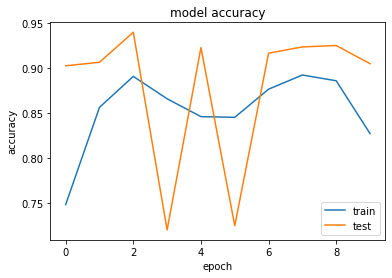

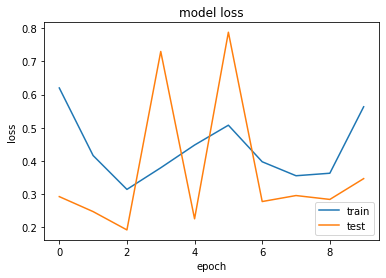

In [60]:
plotTraining(history)

# Adam

Adam is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks.
The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter. It also has advantages of Adagrad, which works really well in settings with sparse gradients, but struggles in non-convex optimization of neural networks, and RMSprop, which tackles to resolve some of the problems of Adagrad and works really well in on-line settings.
Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

This is in huge contrast with Stochastic Gradient Descent, where:



*   learning rates are not per-parameter, but there is a single, global learning rate, that is applied bluntly, across all parameters
*   by the way, this is one reason why data is often normalized, prior to being sent into nets, to try to keep the ideal per-parameter weights similar-ish
*   the learning rate provided is the exact learning rate used, and wont adapt over time



In [61]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.Adam(learning_rate=0.001))

In [62]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_37 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_38 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_40 (Dense)             (None, 4096)              4198

In [63]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 160s 990ms/step - loss: 2.6627 - accuracy: 0.6540 - val_loss: 0.2937 - val_accuracy: 0.9053
Epoch 2/10
161/161 [==============================] - 157s 977ms/step - loss: 0.3640 - accuracy: 0.8684 - val_loss: 0.3122 - val_accuracy: 0.8564
Epoch 3/10
161/161 [==============================] - 157s 973ms/step - loss: 0.3371 - accuracy: 0.8720 - val_loss: 0.2571 - val_accuracy: 0.8711
Epoch 4/10
161/161 [==============================] - 157s 975ms/step - loss: 0.3311 - accuracy: 0.8961 - val_loss: 0.1879 - val_accuracy: 0.9348
Epoch 5/10
161/161 [==============================] - 157s 976ms/step - loss: 0.2624 - accuracy: 0.9050 - val_loss: 0.3430 - val_accuracy: 0.8711
Epoch 6/10
161/161 [==============================] - 157s 976ms/step - loss: 0.2780 - accuracy: 0.8988 - val_loss: 0.1999 - val_accuracy: 0.9286
Epoch 7/10
161/161 [==============================] - 157s 976ms/step - loss: 0.2529 - accuracy: 0.9084 - val_loss: 0.1957 -

In [64]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.14      0.11      0.12       116
           1       0.26      0.26      0.26       317
           2       0.67      0.69      0.68       855

    accuracy                           0.53      1288
   macro avg       0.36      0.35      0.35      1288
weighted avg       0.52      0.53      0.53      1288



In [65]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.10      0.08      0.09       460
           1       0.27      0.27      0.27      1266
           2       0.67      0.69      0.68      3418

    accuracy                           0.53      5144
   macro avg       0.34      0.34      0.34      5144
weighted avg       0.52      0.53      0.52      5144



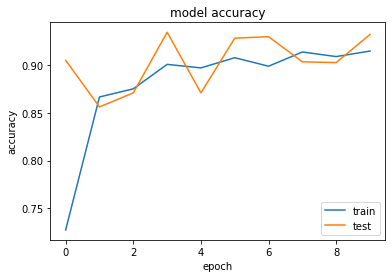

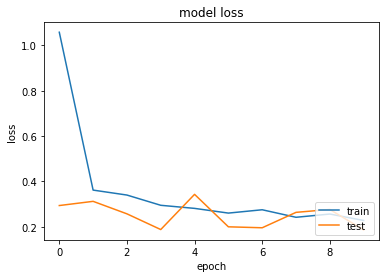

In [66]:
plotTraining(history)

# Q7

In this part, we check out the effect of the number of epochs in the learning process of our model. One Epoch is when an entire dataset is passed forward and backward through the neural network only once. As we can see from the result, our model gets better accuracy as the number of epochs reaches 20. This heppening is logical because previously, we didn't receive to the optima. We should take care overfitting doesn't happen in our model which is not happening now because test and train accuracy are almost the same so we don't have overfitting here.

Gradient Descent is an iterative optimization algorithm used to find the best results. The algorithm is iterative, means that we need to get the results multiple times to get the most optimal result. The iterative quality of the gradient descent helps a under-fitted graph to make the graph fit optimally to the data. As the number of epochs increases, more number of times the weight are changed in the neural network and the curve goes from underfitting to optimal to overfitting curve.

Base on what we said in the last part, increasing the number of epochs doesn't always lead to better results and maybe we face overfitting. So we should take care of this happening.

In [67]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.Adam(learning_rate=0.001))

In [68]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_43 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_44 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_46 (Dense)             (None, 4096)              4198

In [69]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=20)

Epoch 1/20
161/161 [==============================] - 158s 977ms/step - loss: 2.1016 - accuracy: 0.6214 - val_loss: 0.5857 - val_accuracy: 0.7360
Epoch 2/20
161/161 [==============================] - 156s 968ms/step - loss: 0.6358 - accuracy: 0.7426 - val_loss: 0.5340 - val_accuracy: 0.7756
Epoch 3/20
161/161 [==============================] - 156s 970ms/step - loss: 0.3613 - accuracy: 0.8585 - val_loss: 0.2529 - val_accuracy: 0.9084
Epoch 4/20
161/161 [==============================] - 156s 967ms/step - loss: 0.3209 - accuracy: 0.8784 - val_loss: 0.2259 - val_accuracy: 0.9239
Epoch 5/20
161/161 [==============================] - 156s 968ms/step - loss: 0.2797 - accuracy: 0.9019 - val_loss: 0.1975 - val_accuracy: 0.9317
Epoch 6/20
161/161 [==============================] - 155s 964ms/step - loss: 0.2798 - accuracy: 0.8933 - val_loss: 0.2579 - val_accuracy: 0.9022
Epoch 7/20
161/161 [==============================] - 156s 969ms/step - loss: 0.2719 - accuracy: 0.9008 - val_loss: 0.2414 -

In [70]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.13      0.07      0.09       116
           1       0.28      0.36      0.32       317
           2       0.68      0.66      0.67       855

    accuracy                           0.53      1288
   macro avg       0.36      0.36      0.36      1288
weighted avg       0.53      0.53      0.53      1288



In [71]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.08      0.05      0.06       460
           1       0.24      0.30      0.27      1266
           2       0.66      0.64      0.65      3418

    accuracy                           0.51      5144
   macro avg       0.33      0.33      0.33      5144
weighted avg       0.51      0.51      0.51      5144



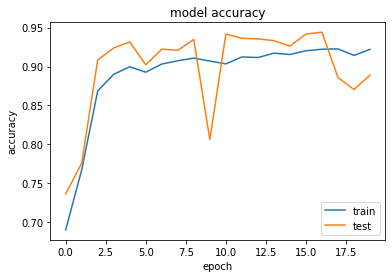

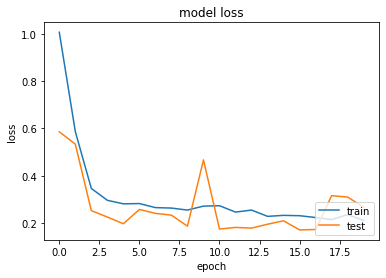

In [72]:
plotTraining(history)

# Q8

As a rule of thumb, mean squared error (MSE) is more appropriate for regression problems, that is, problems where the output is a numerical value (i.e. a floating-point number or, in general, a real number). However, in principle, you can use the MSE for classification problems too (even though that may not be a good idea). MSE can be preceded by the sigmoid function, which outputs a number p∈[0,1], which can be interpreted as the probability of the input belonging to one of the classes, so the probability of the input belonging to the other class is 1−p.

Similarly, cross-entropy (CE) is mainly used for classification problems, that is, problems where the output can belong to one of a discrete set of classes.

Cross-entropy is a better measure than MSE for classification, because the decision boundary in a classification task is large (in comparison with regression). MSE doesn’t punish misclassifications enough but is the right loss for regression, where the distance between two values that can be predicted is small.

From a probabilistic point of view, the cross-entropy arises as the natural cost function to use if you have a softmax nonlinearity in the output layer of your network, and you want to maximize the likelihood of classifying the input data correctly. If instead you assume the target is continuous and normally distributed, and you maximize the likelihood of the output of the net under these assumptions, you get the MSE (combined with a linear output layer). For classification, cross-entropy tends to be more suitable than MSE – the underlying assumptions just make more sense for this setting. That said, you can train a classifier with the MSE loss and it will probably work fine (although it does not play very nicely with the softmax nonlinearities, a linear output layer would be a better choice in that case). For regression problems, you would almost always use the MSE.

In [96]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.MeanSquaredError())

In [98]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_79 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_80 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_81 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_82 (Dense)             (None, 4096)              419

In [99]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 162s 1s/step - loss: 0.2174 - accuracy: 0.6640 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 2/10
161/161 [==============================] - 161s 999ms/step - loss: 0.2227 - accuracy: 0.6660 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 3/10
161/161 [==============================] - 161s 1000ms/step - loss: 0.2188 - accuracy: 0.6718 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 4/10
161/161 [==============================] - 161s 999ms/step - loss: 0.2162 - accuracy: 0.6757 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 5/10
161/161 [==============================] - 160s 997ms/step - loss: 0.2198 - accuracy: 0.6703 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 161s 997ms/step - loss: 0.2251 - accuracy: 0.6624 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 7/10
161/161 [==============================] - 160s 994ms/step - loss: 0.2263 - accuracy: 0.6605 - val_loss: 0.2241 - v

In [100]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


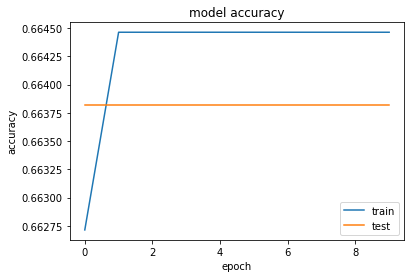

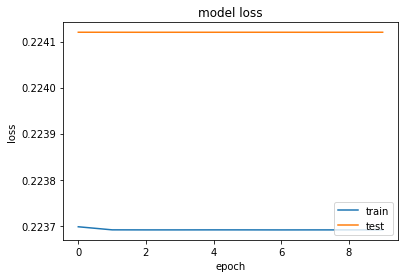

In [102]:
plotTraining(history)

# Q9

# L2 regularization

Overfitting is a phenomenon where a machine learning model models the training data too well but fails to perform well on the testing data. Performing sufficiently good on testing data is considered as a kind of ultimatum in machine learning. There are quite a number of techniques which help to prevent overfitting. Regularization is one such technique. In short, Regularization in machine learning is the process of regularizing the parameters that constrain, regularizes, or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, avoiding the risk of Overfitting. Regularization is a technique used for tuning the function by adding an additional penalty term in the error function. The additional term controls the excessively fluctuating function such that the coefficients don’t take extreme values. This technique of keeping a check or reducing the value of error coefficients are called shrinkage methods or weight decay in case of neural networks.

In [80]:
model = createModel(input_shape=(80, 80, 1), output_class_count=num_classes, optimizer=optimizers.Adam(learning_rate=0.001), kernel_regularizer=regularizers.l2(1e-4))

In [81]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_61 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_62 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_63 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_64 (Dense)             (None, 4096)              419

In [82]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 160s 989ms/step - loss: 3.0395 - accuracy: 0.6706 - val_loss: 0.7740 - val_accuracy: 0.8983
Epoch 2/10
161/161 [==============================] - 159s 986ms/step - loss: 0.7668 - accuracy: 0.8711 - val_loss: 0.5182 - val_accuracy: 0.9239
Epoch 3/10
161/161 [==============================] - 158s 982ms/step - loss: 0.6083 - accuracy: 0.8928 - val_loss: 0.4947 - val_accuracy: 0.9309
Epoch 4/10
161/161 [==============================] - 159s 989ms/step - loss: 0.5647 - accuracy: 0.8857 - val_loss: 0.4224 - val_accuracy: 0.9293
Epoch 5/10
161/161 [==============================] - 159s 987ms/step - loss: 0.4809 - accuracy: 0.9058 - val_loss: 0.3877 - val_accuracy: 0.9348
Epoch 6/10
161/161 [==============================] - 159s 990ms/step - loss: 0.4496 - accuracy: 0.9044 - val_loss: 0.4111 - val_accuracy: 0.9092
Epoch 7/10
161/161 [==============================] - 159s 988ms/step - loss: 0.4324 - accuracy: 0.9034 - val_loss: 0.3620 -

In [83]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.09      0.07      0.08       116
           1       0.25      0.24      0.25       317
           2       0.67      0.70      0.68       855

    accuracy                           0.53      1288
   macro avg       0.34      0.34      0.34      1288
weighted avg       0.51      0.53      0.52      1288



In [84]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.08      0.06      0.07       460
           1       0.25      0.22      0.23      1266
           2       0.66      0.71      0.69      3418

    accuracy                           0.53      5144
   macro avg       0.33      0.33      0.33      5144
weighted avg       0.51      0.53      0.52      5144



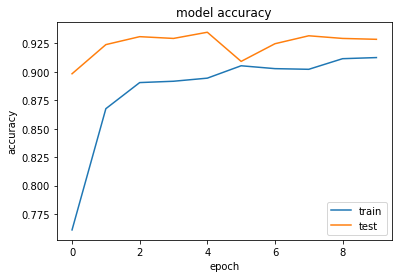

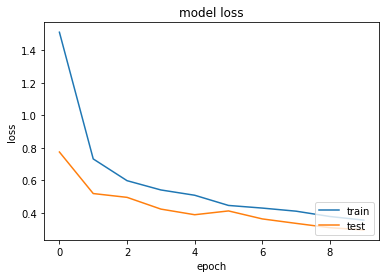

In [85]:
plotTraining(history)

# Dropout

**What is Dropout?**  

*The term “dropout” refers to dropping out units (both hidden and visible) in a neural network.*

Simply put, dropout refers to ignoring neurons during the training phase of certain set of neurons which is chosen at random. “ignoring” means these units are not considered during a particular forward or backward pass.

More technically, At each training stage, individual nodes are either dropped out of the net with probability 1-p or kept with probability p, so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed.

**Why do we need Dropout?**  

The answer to these question is “to prevent over-fitting”.  
A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data.

In [86]:
input_layer = layers.Input(shape=(80, 80, 1))
input_flatten = layers.Flatten()(input_layer)
output = layers.Dropout(0.1)(input_flatten)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(4096, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(4096, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(4096, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(num_classes, activation="softmax")(output)
model = models.Model(
    inputs=input_layer,
    outputs=output
)

In [87]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0  

In [88]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
history = model.fit(trainLoader, validation_data=testLoader, epochs=10)

Epoch 1/10
161/161 [==============================] - 161s 999ms/step - loss: 2.7558 - accuracy: 0.6515 - val_loss: 0.3839 - val_accuracy: 0.8750
Epoch 2/10
161/161 [==============================] - 160s 992ms/step - loss: 0.4413 - accuracy: 0.8397 - val_loss: 0.3998 - val_accuracy: 0.8929
Epoch 3/10
161/161 [==============================] - 160s 993ms/step - loss: 0.3808 - accuracy: 0.8647 - val_loss: 0.2369 - val_accuracy: 0.9247
Epoch 4/10
161/161 [==============================] - 160s 994ms/step - loss: 0.3298 - accuracy: 0.8855 - val_loss: 0.2192 - val_accuracy: 0.9262
Epoch 5/10
161/161 [==============================] - 160s 992ms/step - loss: 0.3237 - accuracy: 0.8810 - val_loss: 0.2271 - val_accuracy: 0.9325
Epoch 6/10
161/161 [==============================] - 160s 993ms/step - loss: 0.3023 - accuracy: 0.8890 - val_loss: 0.2756 - val_accuracy: 0.8998
Epoch 7/10
161/161 [==============================] - 160s 994ms/step - loss: 0.3076 - accuracy: 0.8914 - val_loss: 0.2100 -

In [90]:
preds = model.predict(testLoader)
true_lables = getTrueLabels(testLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.11      0.10      0.11       116
           1       0.25      0.23      0.24       317
           2       0.68      0.71      0.69       855

    accuracy                           0.53      1288
   macro avg       0.35      0.35      0.35      1288
weighted avg       0.52      0.53      0.53      1288



In [91]:
preds = model.predict(trainLoader)
true_lables = getTrueLabels(trainLoader)
print(classification_report(true_lables, backend.argmax(preds).numpy()))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       460
           1       0.25      0.21      0.23      1266
           2       0.67      0.70      0.68      3418

    accuracy                           0.53      5144
   macro avg       0.34      0.34      0.34      5144
weighted avg       0.51      0.53      0.52      5144



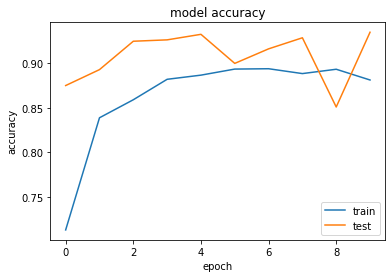

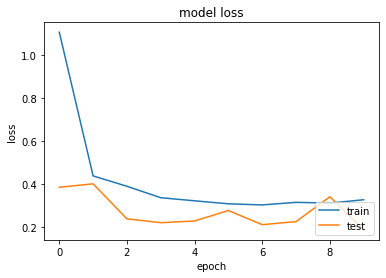

In [92]:
plotTraining(history)